In [2]:
import matplotlib.cm as cm
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

from tqdm import tqdm
from epicare.envs import EpiCare
from epicare.policies import StandardOfCare, ClinicalTrial, Oracle, Random
from epicare.evaluations import run_episode
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FixedLocator

from tueplots import bundles

plt.rcParams.update(bundles.icml2024())
plt.rcParams["figure.dpi"] = 300

results_directory = "../algorithms/results/"

/home/masonhargrave/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-28 21:43:44.898773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 21:43:44.898843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 21:43:44.922257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 21:43:44.977007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary 

## Tables

In [8]:
num_seeds = 8
num_episodes = 1000

all_data = []

for seed in tqdm(range(1, num_seeds + 1)):
    environment = EpiCare(seed=seed)

    # Setting up the policies
    policies = {
        "Random": Random(environment),
        "SMART": ClinicalTrial(environment),
        "SoC": StandardOfCare(environment, alpha=0.8),
        "OP": Oracle(environment),
    }

    # This dictionary will store the stats for each policy
    policy_stats = {}

    # Simulation loop
    for name, policy in policies.items():
        print(f"Running {name} policy")
        for episode in range(num_episodes):
            total_reward, time_to_remission, steps, transitions = (
                run_episode(
                    environment, policy, name, policy_stats, verbose=False
                )
            )

        # After simulation, calculate averages and remission rates
        average_reward = np.mean(policy_stats[name]["total_rewards"])
        reward_std = np.std(policy_stats[name]["total_rewards"])
        remission_rate = np.mean(policy_stats[name]["remission"])
        average_time_to_remission = (
            np.mean(policy_stats[name]["times_to_remission"])
            if policy_stats[name]["times_to_remission"]
            else None
        )
        time_to_remission_std = (
            np.std(policy_stats[name]["times_to_remission"])
            if policy_stats[name]["times_to_remission"]
            else None
        )

        # Adding data to all_data
        all_data.append(
            {
                "policy": name,
                "env_seed": seed,
                "mean_return": average_reward,
                "std_return": reward_std,
                "mean_time_to_remission": average_time_to_remission,
                "std_time_to_remission": time_to_remission_std,
                "mean_remission_rate": remission_rate,
            }
        )

# Creating the final dataframe
df = pd.DataFrame(all_data)
# Saving separate CSV files for each policy
for policy in df["policy"].unique():
    # make policy name lowercase
    policy_df = df[df["policy"] == policy]
    policy_df = policy_df.drop(columns=["policy"])
    policy_df.to_csv(f"{policy.lower()}_results.csv", index=False)

  0%|          | 0/8 [00:00<?, ?it/s]

Running Random policy
Running SMART policy
Running SoC policy


  0%|          | 0/8 [00:04<?, ?it/s]

Running OP policy


KeyError: 'Treatment_Treatment_0'

/tmp/ipykernel_28416/3242153230.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


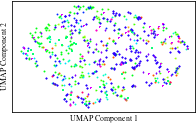

In [2]:
# Create an instance of the environment with default parameters
env = EpiCare()

unique_states = np.arange(env.n_diseases)

# Initialize the Random policy
policy = Random(env)

# Collect observations from the environment during simulation
observations = []
states = []


# Number of episodes for the simulation
num_episodes = 100

for _ in range(num_episodes):
    obs_collected, states_collected = run_episode(
        env, policy, "Random", collect_series=True
    )
    for state, obs in zip(states_collected, obs_collected):
        if "Remission" not in state:  # Ignore remission states
            observations.append(obs)
            # Extract the integer index of the disease state
            state_index = int(state.split("_")[1])  # Assuming the format is 'Disease_X'
            states.append(state_index)

# Convert to numpy arrays and proceed with preprocessing and UMAP
observations = np.array(observations)
states = np.array(states)

# Preprocess the data
observations = StandardScaler().fit_transform(observations)

# Perform UMAP
umap_reducer = umap.UMAP(
    n_components=2, # n_neighbors=3, min_dist=1.0,
)
observations_reduced = umap_reducer.fit_transform(observations)

# Generate a color palette with seaborn
palette = sns.color_palette(
    "hsv", len(unique_states)
)  # "hsv" is a circular color space

# Generate a list of markers
markers = ["o", "v", "^", "<", ">", "8", "s", "p", "*", "h", "H", "D", "d", "P", "X"]

# Plotting the clusters
plt.figure(figsize=(3,2))
for i, (color, marker) in enumerate(
    zip(palette, markers * (len(unique_states) // len(markers) + 1))
):
    state_mask = states == unique_states[i]
    plt.scatter(
        observations_reduced[state_mask, 0],
        observations_reduced[state_mask, 1],
        color=color,
        marker=marker,
        label=f"State {unique_states[i]}",
        s=1,
    )

plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
# Remove x and y ticks
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("umap.pdf")

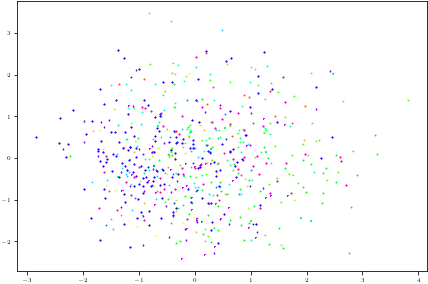

In [10]:
# PCA plot
from sklearn.decomposition import PCA

pca_reducer = PCA(n_components=2)
observations_pca = pca_reducer.fit_transform(observations)

# Plotting the clusters
for i, (color, marker) in enumerate(
    zip(palette, markers * (len(unique_states) // len(markers) + 1))
):
    state_mask = states == unique_states[i]
    plt.scatter(
        observations_pca[state_mask, 0],
        observations_pca[state_mask, 1],
        color=color,
        marker=marker,
        label=f"State {unique_states[i]}",
        s=1,
    )

/home/alex/.local/lib/python3.10/site-packages/asttokens/mark_tokens.py:29: DeprecationWarning: The 'astroid.node_classes' module is deprecated and will be replaced by 'astroid.nodes' in astroid 3.0.0
  import astroid.node_classes as nc # type: ignore[import]


FileNotFoundError: [Errno 2] No such file or directory: '../algorithms/results/iql_restriction.csv'

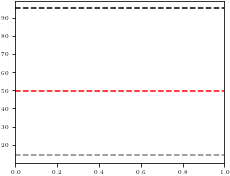

In [4]:
plt.figure(figsize=(3.25, 2.5))  # Adjust the figure size as needed for a half-page plot

models = ["iql", "cql", "td3_bc"]  # List of models to plot
labels = ["IQL", "CQL", "TD3+BC"]  # List of labels for the legend

# Adding a horizontal line for typical SoC performance
plt.axhline(y=95.5, color="k", linestyle="--", label="OP")
plt.axhline(y=49.5, color="r", linestyle="--", label="SoC")
plt.axhline(y=14.1, color="gray", linestyle="--", label="Random")

for model in models:
    df = pd.read_csv(os.path.join(results_directory, model + "_restriction.csv"))
    grouped = df.groupby(["episodes_avail"])
    mean = grouped["mean_return"].mean()
    std = grouped["mean_return"].std()

    # Plotting mean
    plt.plot(
        mean.index, mean, marker="o", label=labels[models.index(model)], markersize=4
    )

    # Adding shaded error (std deviation)
    plt.fill_between(mean.index, mean - std, mean + std, alpha=0.2)

# Setting a logarithmic scale for the x-axis
plt.xscale("log")

# Labels and title
plt.xlabel("Episodes Available")
plt.ylabel("Mean Episode Reward")

# Making the legend readable and not overlap with the plot
plt.legend(title="Model/Policy", loc="lower right")

# Fine-tuning the appearance
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits into the figure area

# Saving the figure
plt.savefig("data_restriction.pdf")

# Display the plot
plt.show()

In [12]:
from epicare.policies import BasePolicy, _q_star_values

class NewStandardOfCare(BasePolicy):
    """
    A state-agnostic greedy policy that selects the treatment with the highest remission probability.
    """

    def __init__(self, env, alpha=0.5, kappa=0.2):
        self.alpha = alpha  # Learning rate for updating estimates
        self.max_allowable_symptom = 1 - kappa
        super().__init__(env)

    def get_treatment(self, observation):
        # Limit the possible treatments to only those which do not increase any symptom
        # that is currently at or above the policy's adverse event threshold.
        self.max_observation = np.maximum(self.max_observation, observation)
        high_symptoms = self.max_observation > self.max_allowable_symptom
        allowed = [
            i
            for i, treatment in enumerate(self.env.treatments.values())
            if np.all(treatment["treatment_effects"][high_symptoms] <= 0)
        ]

        # Select the allowed treatment with the highest Q-value, falling back on
        # considering all treatments if none are safe.
        return max(allowed or self.Q, key=self.Q.get)

    def update(self, treatment, reward):
        # Update the Q-value for the chosen treatment based on the reward received
        self.Q[treatment] = (1 - self.alpha) * self.Q[treatment] + self.alpha * reward

    def reset(self):
        self.Q = _q_star_values(self.env)
        self.max_observation = 0



100%|███████████████████████████████████████████████████████████████| 300000/300000 [06:22<00:00, 783.41it/s]
/tmp/ipykernel_28416/289601118.py:117: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


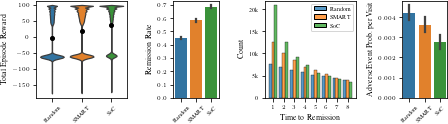

Number of transitions per episode:  1.4176


In [14]:
num_seeds = 100  # Number of random seeds
num_episodes = 1000  # Number of evaluation episodes

# Initialize containers for aggregated data
all_rewards = []
all_remission_rates = []
all_times_to_remission = []
all_adverse_rates = []
num_steps = 0
num_transitions = 0

with tqdm(total=3 * num_episodes * num_seeds) as pbar:
    for seed in range(num_seeds):
        environment = EpiCare(seed=seed)

        # Setting up the policies
        policy_stats = {}
        policies = {
            "Random": Random(environment),
            "SMART": ClinicalTrial(environment),
            "SoC": StandardOfCare(environment),
        }

        # Simulation loop
        policy_stats = {}
        for name, policy in policies.items():
            for episode in range(num_episodes):
                total_reward, time_to_remission, steps, transitions = run_episode(
                    environment, policy, name, policy_stats, verbose=False
                )
                policy_stats[name]["adverse_event"][-1] /= steps
                num_steps += steps
                num_transitions += transitions
                pbar.update()

        # After simulation, calculate averages and remission rates
        for stats in policy_stats.values():
            stats["average_reward"] = np.mean(stats["total_rewards"])
            stats["reward_std"] = np.std(stats["total_rewards"])
            stats["remission_rate"] = np.mean(stats["remission"])
            stats["adverse_rate"] = np.mean(stats["adverse_event"])
            if stats["times_to_remission"]:
                stats["average_time_to_remission"] = np.mean(stats["times_to_remission"])
            else:
                stats["average_time_to_remission"] = None

        policy_names = list(policy_stats.keys())

        # Process and store data for each seed
        df_rewards = pd.DataFrame.from_records(
            [policy_stats[name]["total_rewards"] for name in policy_names]
        ).T
        df_rewards.columns = policy_names
        all_rewards.append(df_rewards)

        remission_rates = [
            np.average(policy_stats[name]["remission_rate"]) for name in policy_names
        ]
        all_remission_rates.append(remission_rates)
        
        adverse_rates = [
            np.average(policy_stats[name]["adverse_rate"]) for name in policy_names
        ]
        all_adverse_rates.append(adverse_rates)

        df_times_to_remission = pd.DataFrame.from_records(
            [policy_stats[name]["times_to_remission"] for name in policy_names]
        ).T
        df_times_to_remission.columns = policy_names
        df_times_to_remission = df_times_to_remission.astype("Int64")
        all_times_to_remission.append(df_times_to_remission)

# Aggregate data across all seeds
agg_rewards = (pd.concat(all_rewards) / 64) * 100
agg_remission_rates = pd.DataFrame(all_remission_rates, columns=policy_names)
agg_times_to_remission = pd.concat(all_times_to_remission)
agg_adverse_rates = pd.DataFrame(all_adverse_rates, columns=policy_names)

# Boxplot setup
fig, axes = plt.subplots(1, 4, figsize=(6.5, 2.0), width_ratios=[2,1,2,1])

# Aggregate plots
# Plot 1: Total Reward
sns.violinplot(data=agg_rewards, ax=axes[0], bw_adjust=0.1, inner=None)
# Mark the mean for each policy
for i, name in enumerate(policy_names):
    axes[0].plot(i, agg_rewards[name].mean(), "o", color="black", markersize=4)
axes[0].set_ylabel("Total Episode Reward")

# Plot 2: Remission Rate
sns.barplot(data=agg_remission_rates, ax=axes[1])
axes[1].set_ylabel("Remission Rate")

# Plot 3: Time to Remission
sns.histplot(
    data=agg_times_to_remission, ax=axes[2], multiple="dodge", discrete=True, shrink=0.8
)
axes[2].set_ylabel("Count")
axes[2].yaxis
axes[2].set_xlabel("Time to Remission")
axes[2].set_xticks(range(1, environment.max_visits + 1))
axes[2].axes.yaxis.set_major_formatter(lambda value, text: str(int(value/1000))+"k" if value > 0 else "0")

# Plot 4: Adverse Event Rate
sns.barplot(data=agg_adverse_rates, ax=axes[3])
axes[3].set_ylabel("Adverse Event Rate")

# Fine-tuning the aesthetics for publication quality
for ax in axes:
    if ax != axes[2]:
        ax.tick_params(axis="x", labelrotation=45)
    ax.tick_params(axis="both", which="major")
    if ax == axes[1]:
        ax.set_ylim(bottom=0)

# Adjusting the layout to prevent overlap
plt.tight_layout()

plt.savefig("compare_policies.pdf")

# Display plots
plt.show()

print(
    "Number of transitions per episode: ",
    num_transitions / (num_episodes * num_seeds * 3),
)

/tmp/ipykernel_28416/1624777400.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


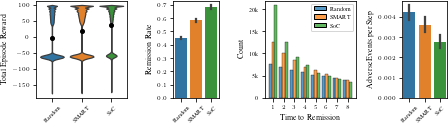

Number of transitions per episode:  1.4176


In [16]:

# Boxplot setup
fig, axes = plt.subplots(1, 4, figsize=(6.5, 2.0), width_ratios=[2,1,2,1])

# Aggregate plots
# Plot 1: Total Reward
sns.violinplot(data=agg_rewards, ax=axes[0], bw_adjust=0.1, inner=None)
# Mark the mean for each policy
for i, name in enumerate(policy_names):
    axes[0].plot(i, agg_rewards[name].mean(), "o", color="black", markersize=4)
axes[0].set_ylabel("Total Episode Reward")

# Plot 2: Remission Rate
sns.barplot(data=agg_remission_rates, ax=axes[1])
axes[1].set_ylabel("Remission Rate")

# Plot 3: Time to Remission
sns.histplot(
    data=agg_times_to_remission, ax=axes[2], multiple="dodge", discrete=True, shrink=0.8
)
axes[2].set_ylabel("Count")
axes[2].yaxis
axes[2].set_xlabel("Time to Remission")
axes[2].set_xticks(range(1, environment.max_visits + 1))
axes[2].axes.yaxis.set_major_formatter(lambda value, text: str(int(value/1000))+"k" if value > 0 else "0")

# Plot 4: Adverse Event Rate
sns.barplot(data=agg_adverse_rates, ax=axes[3])
axes[3].set_ylabel("Adverse Events per Step")

# Fine-tuning the aesthetics for publication quality
for ax in axes:
    if ax != axes[2]:
        ax.tick_params(axis="x", labelrotation=45)
    ax.tick_params(axis="both", which="major")
    if ax == axes[1]:
        ax.set_ylim(bottom=0)

# Adjusting the layout to prevent overlap
plt.tight_layout()

plt.savefig("compare_policies.pdf")

# Display plots
plt.show()

print(
    "Number of transitions per episode: ",
    num_transitions / (num_episodes * num_seeds * 3),
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1100000/1100000 [22:09<00:00, 827.68it/s]
/tmp/ipykernel_51681/2050064621.py:121: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


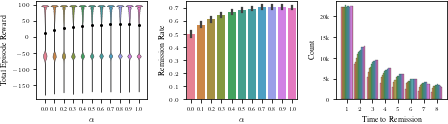

In [110]:
num_seeds = 100  # Number of random seeds
num_episodes = 1000  # Number of separate evaluation episodes

# Initialize containers for aggregated data
all_rewards = []
all_remission_rates = []
all_times_to_remission = []
all_adverse_rates = []
num_steps = 0
num_transitions = 0

with tqdm(total=11*num_episodes*num_seeds) as pbar:
    for seed in range(num_seeds):
        environment = EpiCare(seed=seed)

        # Setting up the policies
        policy_stats = {}
        # SoC with all alphas between 0 and 1, in increments of 0.1
        policies = {
            f"{alpha:.1f}": StandardOfCare(environment, alpha=alpha)
            for alpha in [i * 0.1 for i in range(11)]
        }

        # Simulation loop
        policy_stats = {}
        for name, policy in policies.items():
            for episode in range(num_episodes):
                total_reward, time_to_remission, steps, transitions = run_episode(
                    environment, policy, name, policy_stats, verbose=False
                )
                num_steps += steps
                num_transitions += transitions
                pbar.update()

        # After simulation, calculate averages and remission rates
        for stats in policy_stats.values():
            stats["average_reward"] = np.mean(stats["total_rewards"])
            stats["reward_std"] = np.std(stats["total_rewards"])
            stats["remission_rate"] = np.mean(stats["remission"])
            stats["adverse_rate"] = np.mean(stats["adverse_event"])
            if stats["times_to_remission"]:
                stats["average_time_to_remission"] = np.mean(stats["times_to_remission"])
            else:
                stats["average_time_to_remission"] = None

        policy_names = list(policy_stats.keys())

        # Process and store data for each seed
        df_rewards = pd.DataFrame.from_records(
            [policy_stats[name]["total_rewards"] for name in policy_names]
        ).T
        df_rewards.columns = policy_names
        all_rewards.append(df_rewards)

        remission_rates = [
            np.average(policy_stats[name]["remission_rate"]) for name in policy_names
        ]
        all_remission_rates.append(remission_rates)
        
        adverse_rates = [
            np.average(policy_stats[name]["adverse_rate"]) for name in policy_names
        ]
        all_adverse_rates.append(adverse_rates)

        df_times_to_remission = pd.DataFrame.from_records(
            [policy_stats[name]["times_to_remission"] for name in policy_names]
        ).T
        df_times_to_remission.columns = policy_names
        df_times_to_remission = df_times_to_remission.astype("Int64")
        all_times_to_remission.append(df_times_to_remission)

# Aggregate data across all seeds
agg_rewards = (pd.concat(all_rewards) / 64) * 100
agg_remission_rates = pd.DataFrame(all_remission_rates, columns=policy_names)
agg_times_to_remission = pd.concat(all_times_to_remission)
agg_adverse_rates = pd.DataFrame(all_adverse_rates, columns=policy_names)

# Generate a list of alpha values as strings for the x-axis labels
fig, axes = plt.subplots(1, 3, figsize=(6.5, 2.0))

# Plot 1: Total Reward
sns.violinplot(
    data=agg_rewards, ax=axes[0], bw_adjust=0.1, cut=0.0, inner=None, linewidth=0.5
)
for i, alpha in enumerate(policies):
    axes[0].plot(i, agg_rewards[alpha].mean(), "o", color="black", markersize=2)
axes[0].set_ylabel("Total Episode Reward")
axes[0].set_xlabel("$\\alpha$")

# Plot 2: Remission Rate
sns.barplot(data=agg_remission_rates, ax=axes[1])
axes[1].set_ylabel("Remission Rate")
axes[1].set_xlabel("$\\alpha$")

# Plot 3: Time to Remission
sns.histplot(
    data=agg_times_to_remission.melt(var_name="Policy", value_name="Time_to_Remission"),
    x="Time_to_Remission",
    hue="Policy",
    ax=axes[2],
    multiple="dodge",
    discrete=True,
    shrink=0.9,
    linewidth=0.2,
)
axes[2].set_ylabel("Count")
axes[2].set_xlabel("Time to Remission")
axes[2].set_xticks(range(1, environment.max_visits + 1))
# remove legend completely
axes[2].get_legend().remove()
axes[2].axes.yaxis.set_major_formatter(lambda value, text: str(int(value/1000))+"k" if value > 0 else "0")

# Fine-tuning the aesthetics for publication quality
for ax in axes:
    ax.tick_params(axis="x", labelrotation=0)
    ax.tick_params(axis="both", which="major")
    if ax == axes[1]:
        ax.set_ylim(bottom=0)

# Adjusting the layout to prevent overlap
plt.tight_layout()

plt.savefig("SoC_alpha.pdf")

# Display plots
plt.show()

100%|███████████████████████████████████████████████████████████| 6000000/6000000 [1:53:39<00:00, 879.81it/s]
/tmp/ipykernel_28416/4040674134.py:125: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


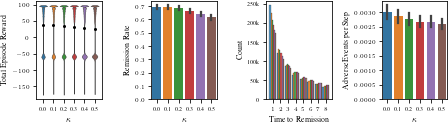

In [19]:
num_seeds = 100  # Number of random seeds
num_episodes = 10000  # Number of separate evaluation episodes

# Initialize containers for aggregated data
all_rewards = []
all_remission_rates = []
all_times_to_remission = []
all_adverse_rates = []
num_steps = 0
num_transitions = 0

with tqdm(total=6*num_episodes*num_seeds) as pbar:
    for seed in range(num_seeds):
        environment = EpiCare(seed=seed)

        # Setting up the policies
        policy_stats = {}
        # SoC with all kappas between 0 and 0.5, in increments of 0.1
        policies = {
            f"{kappa:.1f}": StandardOfCare(environment, kappa=kappa)
            for kappa in [i * 0.1 for i in range(6)]
        }

        # Simulation loop
        policy_stats = {}
        for name, policy in policies.items():
            for episode in range(num_episodes):
                total_reward, time_to_remission, steps, transitions = run_episode(
                    environment, policy, name, policy_stats, verbose=False
                )
                policy_stats[name]["adverse_event"][-1] /= steps
                num_steps += steps
                num_transitions += transitions
                pbar.update()

        # After simulation, calculate averages and remission rates
        for stats in policy_stats.values():
            stats["average_reward"] = np.mean(stats["total_rewards"])
            stats["reward_std"] = np.std(stats["total_rewards"])
            stats["remission_rate"] = np.mean(stats["remission"])
            stats["adverse_rate"] = np.mean(stats["adverse_event"])
            if stats["times_to_remission"]:
                stats["average_time_to_remission"] = np.mean(stats["times_to_remission"])
            else:
                stats["average_time_to_remission"] = None

        policy_names = list(policy_stats.keys())

        # Process and store data for each seed
        df_rewards = pd.DataFrame.from_records(
            [policy_stats[name]["total_rewards"] for name in policy_names]
        ).T
        df_rewards.columns = policy_names
        all_rewards.append(df_rewards)

        remission_rates = [
            np.average(policy_stats[name]["remission_rate"]) for name in policy_names
        ]
        all_remission_rates.append(remission_rates)
        
        adverse_rates = [
            np.average(policy_stats[name]["adverse_rate"]) for name in policy_names
        ]
        all_adverse_rates.append(adverse_rates)

        df_times_to_remission = pd.DataFrame.from_records(
            [policy_stats[name]["times_to_remission"] for name in policy_names]
        ).T
        df_times_to_remission.columns = policy_names
        df_times_to_remission = df_times_to_remission.astype("Int64")
        all_times_to_remission.append(df_times_to_remission)

# Aggregate data across all seeds, then plot
agg_rewards = (pd.concat(all_rewards) / 64) * 100
agg_remission_rates = pd.DataFrame(all_remission_rates, columns=policy_names)
agg_times_to_remission = pd.concat(all_times_to_remission)
agg_adverse_rates = pd.DataFrame(all_adverse_rates, columns=policy_names)
fig, axes = plt.subplots(1, 4, figsize=(6.5, 2.0))

# Plot 1: Total Reward
sns.violinplot(
    data=agg_rewards, ax=axes[0], bw_adjust=0.1, cut=0.0, inner=None, linewidth=0.5
)
for i, kappa in enumerate(policies):
    axes[0].plot(i, agg_rewards[kappa].mean(), "o", color="black", markersize=2)
axes[0].set_ylabel("Total Episode Reward")
axes[0].set_xlabel("$\\kappa$")

# Plot 2: Remission Rate
sns.barplot(data=agg_remission_rates, ax=axes[1])
axes[1].set_ylabel("Remission Rate")
axes[1].set_xlabel("$\\kappa$")

# Plot 3: Time to Remission
sns.histplot(
    data=agg_times_to_remission.melt(var_name="Policy", value_name="Time_to_Remission"),
    x="Time_to_Remission",
    hue="Policy",
    ax=axes[2],
    multiple="dodge",
    discrete=True,
    shrink=0.9,
    linewidth=0.2,
)
axes[2].set_ylabel("Count")
axes[2].set_xlabel("Time to Remission")
axes[2].set_xticks(range(1, environment.max_visits + 1))
# remove legend completely
axes[2].get_legend().remove()
axes[2].axes.yaxis.set_major_formatter(lambda value, text: str(int(value/1000))+"k" if value > 0 else "0")

# Plot 4: Adverse Event Rate
sns.barplot(data=agg_adverse_rates, ax=axes[3])
axes[3].set_ylabel("Adverse Events per Step")
axes[3].set_xlabel("$\\kappa$")

# Fine-tuning the aesthetics for publication quality
for ax in axes:
    ax.tick_params(axis="x", labelrotation=0)
    ax.tick_params(axis="both", which="major")
    if ax == axes[1]:
        ax.set_ylim(bottom=0)

# Adjusting the layout to prevent overlap
plt.tight_layout()

plt.savefig("SoC_kappa.pdf")

# Display plots
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define OPE methods and models
models = ["awac", "edac", "td3_bc", "iql", "cql"]
model_labels = ["AWAC", "EDAC", "TD3+BC", "IQL", "CQL"]
ope_methods = ["is", "wis", "pdis", "wpdis"]
colors = ["b", "g", "r", "c", "m"]
color_dict = dict(zip(models, colors))
model_labes_dict = dict(zip(models, model_labels))

# Initialize lists to store mean log_probs, their standard deviations, and average RMSE for each model
mean_log_probs = []
std_devs = []
average_rmse_values = []

# Process data for each model to get log_probs and calculate RMSE
for model in models:
    df = pd.read_csv(os.path.join(results_directory, model + "_results.csv"))
    # Filter rows for checkpoint_32.pt
    if "checkpoint" in df.columns:
        df_filtered = df[df["checkpoint"] == "checkpoint_32.pt"]
        abs_log_probs = df_filtered["mean_meanlogprob_estimate"].abs()
        mean_log_prob = abs_log_probs.mean()
        std_dev = abs_log_probs.std()
    else:
        mean_log_prob = std_dev = np.nan

    mean_log_probs.append(mean_log_prob)
    std_devs.append(std_dev)

    # Calculate RMSE for each model across all OPE methods
    rmse_values = []
    for method in ope_methods:
        online_means = df["mean_return"]
        ope_means = df[f"mean_{method}_estimate"]
        rmse = np.sqrt(
            np.mean(
                (np.clip(ope_means, -100, 100) - np.clip(online_means, -100, 100)) ** 2
            )
        )
        rmse_values.append(rmse)
    average_rmse = np.mean(rmse_values)
    average_rmse_values.append(average_rmse)

# Combine models, their mean log_probs, std_devs, and average RMSE into a DataFrame for sorting
model_data = pd.DataFrame(
    {
        "Model": models,
        "MeanLogProb": mean_log_probs,
        "StdDev": std_devs,
        "AverageRMSE": average_rmse_values,
    }
)

# Sort by MeanLogProb from smallest to largest
model_data_sorted = model_data.sort_values(by="MeanLogProb")


# Create a bar graph with error bars for MeanLogProb
fig, ax1 = plt.subplots()
ax1.bar(
    model_data_sorted["Model"],
    model_data_sorted["MeanLogProb"],
    yerr=model_data_sorted["StdDev"],
    color=[color_dict[model] for model in model_data_sorted["Model"]],
    capsize=5,
)
ax1.set_xlabel("Model")
ax1.set_ylabel("Mean Abs Log Probability", color="b")
ax1.tick_params(axis="y", labelcolor="b")
ax1.set_xticklabels([model_labes_dict[model] for model in model_data_sorted["Model"]])

# Add a secondary y-axis for Average RMSE
ax2 = ax1.twinx()
ax2.plot(
    model_data_sorted["Model"],
    model_data_sorted["AverageRMSE"],
    color="red",
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=2,
)
ax2.set_ylabel("Average OPE RMSE", color="r")
ax2.tick_params(axis="y", labelcolor="r")

plt.tight_layout()
plt.savefig("log_probs_and_rmse.pdf")  # Save as high-resolution image
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define OPE methods and models
models = ["awac", "edac", "td3_bc", "iql", "cql"]
model_labels = ["AWAC", "EDAC", "TD3+BC", "IQL", "CQL"]
colors = ["b", "g", "r", "c", "m"]
colord_dict = dict(zip(models, colors))
model_labes_dict = dict(zip(models, model_labels))

# Initialize lists to store mean log_probs, their standard deviations, and average RMSE for each model
mean_times_to_remission = []
std_devs = []
average_rmse_values = []

# Process data for each model to get log_probs and calculate RMSE
for model in models:
    df = pd.read_csv(os.path.join(results_directory, model + "_results.csv"))
    # Filter rows for checkpoint_32.pt
    if "checkpoint" in df.columns:
        df_filtered = df[df["checkpoint"] == "checkpoint_32.pt"]
        time_to_remission = df_filtered["mean_time_to_remission"]
        mean_time_to_remission = time_to_remission.mean()
        std_dev = time_to_remission.std()
    else:
        mean_time_to_remission = std_dev = np.nan

    mean_times_to_remission.append(mean_time_to_remission)
    std_devs.append(std_dev)

    # Calculate RMSE for each model across all OPE methods
    rmse_values = []
    for method in ope_methods:
        online_means = df["mean_return"]
        ope_means = df[f"mean_{method}_estimate"]
        rmse = np.sqrt(
            np.mean(
                (np.clip(ope_means, -100, 100) - np.clip(online_means, -100, 100)) ** 2
            )
        )
        rmse_values.append(rmse)
    average_rmse = np.mean(rmse_values)
    average_rmse_values.append(average_rmse)

model_data = pd.DataFrame(
    {
        "Model": models,
        "MeanTimeToRemission": mean_times_to_remission,
        "StdDev": std_devs,
        "AverageRMSE": average_rmse_values,
    }
)

# Sort by MeanLogProb from smallest to largest
model_data_sorted = model_data.sort_values(by="MeanTimeToRemission")


# Create a bar graph with error bars for MeanLogProb
fig, ax1 = plt.subplots()
ax1.bar(
    model_data_sorted["Model"],
    model_data_sorted["MeanTimeToRemission"],
    yerr=model_data_sorted["StdDev"],
    color=[colord_dict[model] for model in model_data_sorted["Model"]],
    capsize=5,
)
ax1.set_ylabel("Mean Time to Remission", color="b")
ax1.tick_params(axis="y", labelcolor="b")
ax1.set_xticklabels([model_labes_dict[model] for model in model_data_sorted["Model"]])

# Add a secondary y-axis for Average RMSE
ax2 = ax1.twinx()
ax2.plot(
    model_data_sorted["Model"],
    model_data_sorted["AverageRMSE"],
    color="red",
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=2,
)
ax2.set_ylabel("Average OPE RMSE", color="r")
ax2.tick_params(axis="y", labelcolor="r")

plt.tight_layout()
plt.savefig("ttr_and_rmse.pdf")  # Save as high-resolution image
plt.show()

In [ ]:
ope_methods = ["is", "wis", "pdis", "wpdis"]
models = ["awac", "edac", "td3_bc", "iql", "cql"]

# Create a figure with subplots
fig, axes = plt.subplots(
    ncols=len(models), nrows=len(ope_methods), figsize=(6.75, 5.5)
)  # Adjust size as needed

# Initialize a dictionary to store RMSE values for each model
model_rmse = {model: [] for model in models}

# Process data for each model and each OPE method
for col, model in enumerate(models):
    for row, method in enumerate(ope_methods):
        df = pd.read_csv(os.path.join(results_directory, model + "_results.csv"))
        online_means = df["mean_return"]
        ope_means = df[f"mean_{method}_estimate"]

        # Clip the values to be between -100 and 100
        online_means = np.clip(online_means, -100, 100)
        ope_means = np.clip(ope_means, -100, 100)

        # Calculate RMSE and store it
        rmse = np.sqrt(np.mean((online_means - ope_means) ** 2))
        model_rmse[model].append(rmse)

        # Plot scatter for each method and model
        axes[row, col].scatter(online_means, ope_means, s=5, alpha=0.5)
        axes[row, col].set_aspect("equal", adjustable="box")
        axes[row, col].set_xlim([-75, 100])
        axes[row, col].set_ylim([-75, 100])
        axes[row, col].plot([-75, 100], [-75, 100], color="black")  # y=x line
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

        # Add RMSE as an insert
        axes[row, col].text(
            0.1,
            0.2,
            f"RMSE: {rmse:0.2f}",
            transform=axes[row, col].transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.3", alpha=1.0, facecolor="white"),
        )

for row in range(len(ope_methods)):
    axes[row, 0].set_ylabel(ope_methods[row].upper() + " Estimate")
    axes[row, 0].set_yticks([-75, 0, 100])

for col in range(len(models)):
    axes[0, col].set_title(models[col].upper())
    axes[-1, col].set_xlabel("Online Return")
    axes[-1, col].xaxis.tick_bottom()
    axes[-1, col].set_xticks([-75, 0, 100])

plt.tight_layout()
plt.savefig("ope_scatter.pdf")  # Save as high-resolution image
plt.show()

# Calculate and print average RMSE for each model
average_rmse = {model: np.mean(rmses) for model, rmses in model_rmse.items()}
print("Average RMSE for each model:", average_rmse)